In [13]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [14]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [15]:
IM_SHAPE=(224,224)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [16]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
#from keras.applications import DenseNet121

from keras.applications import resnet_v2
vgg =  resnet_v2.ResNet50V2(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

In [18]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f9d6024fc10>,input_2,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f9d102f1e50>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7f9d602238d0>,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D object at 0x7f9d8dab8b10>,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7f9d61210410>,pool1_pool,False
...,...,...,...
186,<keras.layers.convolutional.Conv2D object at 0x7f9904145b10>,conv5_block3_3_conv,False
187,<keras.layers.merge.Add object at 0x7f9904141450>,conv5_block3_out,False
188,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9d614a0590>,post_bn,False
189,<keras.layers.core.Activation object at 0x7f990415f0d0>,post_relu,False


In [19]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


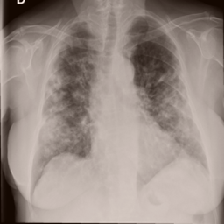

In [20]:
array_to_img(train_generator_NEW[0][0][0])

(32, 7, 7, 2048)


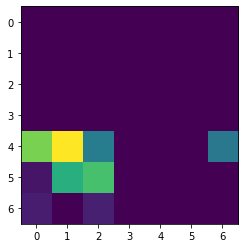

In [21]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [22]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
model_TF.add(Dense(1024, activation='relu')) 
model_TF.add(Dropout(0.25)) 
model_TF.add(Dense(512, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            23564800  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [23]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [24]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 153s 332ms/step - loss: 0.3944 - accuracy: 0.8605 - f1_m: 0.7877 - precision_m: 0.7541 - recall_m: 0.8318 - val_loss: 0.1286 - val_accuracy: 0.9542 - val_f1_m: 0.9344 - val_precision_m: 0.9118 - val_recall_m: 0.9593
Epoch 2/15
452/452 [==============================] - 77s 170ms/step - loss: 0.1650 - accuracy: 0.9333 - f1_m: 0.8872 - precision_m: 0.8400 - recall_m: 0.9424 - val_loss: 0.1220 - val_accuracy: 0.9534 - val_f1_m: 0.9431 - val_precision_m: 0.9237 - val_recall_m: 0.9641
Epoch 3/15
452/452 [==============================] - 78s 172ms/step - loss: 0.1208 - accuracy: 0.9521 - f1_m: 0.9247 - precision_m: 0.9042 - recall_m: 0.9483 - val_loss: 0.1146 - val_accuracy: 0.9548 - val_f1_m: 0.9527 - val_precision_m: 0.9631 - val_recall_m: 0.9429
Epoch 4/15
452/452 [==============================] - 78s 173ms/step - loss: 0.0922 - accuracy: 0.9658 - f1_m: 0.9478 - precision_m: 0.9381 - recall_m: 0.9588 - val_loss: 0.1029 - val_accuracy: 0.9614 - 

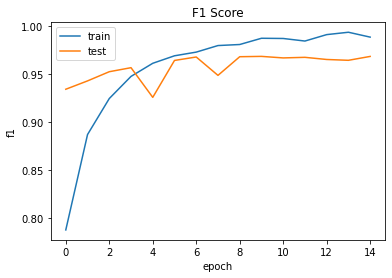

In [25]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 20s 322ms/step - loss: 0.1849 - accuracy: 0.9555 - f1_m: 0.9555 - precision_m: 0.9569 - recall_m: 0.9544


In [27]:
test_loss

[0.18488851189613342,
 0.9555000066757202,
 0.9555265307426453,
 0.9568560719490051,
 0.954365074634552]

In [28]:
from keras.applications import resnet_v2
dense =  resnet_v2.ResNet50V2(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True
dense_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [29]:
model = Sequential() 

model.add(dense_model) 
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 100352)            23564800  
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [31]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 108s 228ms/step - loss: 0.1818 - accuracy: 0.9320 - f1_m: 0.9190 - precision_m: 0.9061 - recall_m: 0.9339 - val_loss: 0.0771 - val_accuracy: 0.9748 - val_f1_m: 0.9731 - val_precision_m: 0.9699 - val_recall_m: 0.9765
Epoch 2/15
452/452 [==============================] - 103s 228ms/step - loss: 0.0480 - accuracy: 0.9819 - f1_m: 0.9772 - precision_m: 0.9716 - recall_m: 0.9832 - val_loss: 0.1051 - val_accuracy: 0.9701 - val_f1_m: 0.9693 - val_precision_m: 0.9690 - val_recall_m: 0.9697
Epoch 3/15
452/452 [==============================] - 102s 226ms/step - loss: 0.0158 - accuracy: 0.9943 - f1_m: 0.9928 - precision_m: 0.9910 - recall_m: 0.9948 - val_loss: 0.0737 - val_accuracy: 0.9798 - val_f1_m: 0.9785 - val_precision_m: 0.9757 - val_recall_m: 0.9814
Epoch 4/15
452/452 [==============================] - 102s 224ms/step - loss: 0.0127 - accuracy: 0.9954 - f1_m: 0.9945 - precision_m: 0.9931 - recall_m: 0.9961 - val_loss: 0.3483 - val_accur

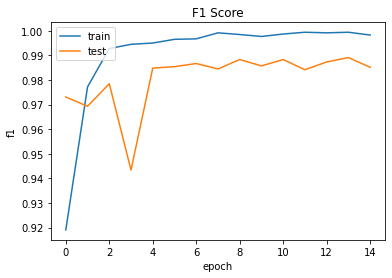

In [32]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 8s 118ms/step - loss: 0.0645 - accuracy: 0.9850 - f1_m: 0.9844 - precision_m: 0.9847 - recall_m: 0.9841


In [34]:
test_loss

[0.06452292203903198,
 0.9850000143051147,
 0.9843862056732178,
 0.9846681356430054,
 0.9841269850730896]